In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow import keras

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Lego_Bricks_All",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7300 files belonging to 56 classes.


In [4]:
class_names = dataset.class_names
class_names

['11214 Bush 3M friction with Cross axle',
 '14719 flat tile corner 2x2',
 '15672 roof tile 1x2',
 '18651 Cross Axle 2M with Snap friction',
 '2357 brick corner 1x2x2',
 '2420 plate corner 2x2',
 '2780 Peg with friction',
 '27925 flat tile round 2x2',
 '3001 brick 2x4',
 '3002 brick 2x3',
 '3003 brick 2x2',
 '3004 brick 1x2',
 '3005 brick 1x1',
 '3010 brick 1x4',
 '3020 plate 2x4',
 '3021 plate 2x3',
 '3022 Plate 2x2',
 '3023 Plate 1x2',
 '3024 plate 1x1',
 '3037 roof tile 1x4',
 '3038 roof tile 2x3',
 '3039 roof tile 2x2',
 '3040 Roof Tile 1x2x45deg',
 '3040 roof tile 1x2',
 '3045 roof corner outside tile 2x2',
 '3046 roof corner inside tile 2x2 000L',
 '3062 Round Brick 1x1',
 '3063 Curved Brick 2 Knobs',
 '3068 flat tile 2x2',
 '3069 Flat Tile 1x2',
 '3070 Flat Tile 1x1',
 '32123 half Bush',
 '3298 roof tile 2x3',
 '33909 plate 2 knobs 2x2',
 '3622 brick 1x3',
 '3623 Plate 1x3',
 '3659 brick bow 1x4',
 '3673 Peg 2M',
 '3675 roof tile outside 3x3',
 '3700 Technic Brick 1x2',
 '3713 B

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[21 41 28 11 45 25 37 18 13  4 14 26 27  9 49 30 16  6 14 33 31 10 11 32
 10 12 41 22 10 14 30 41]


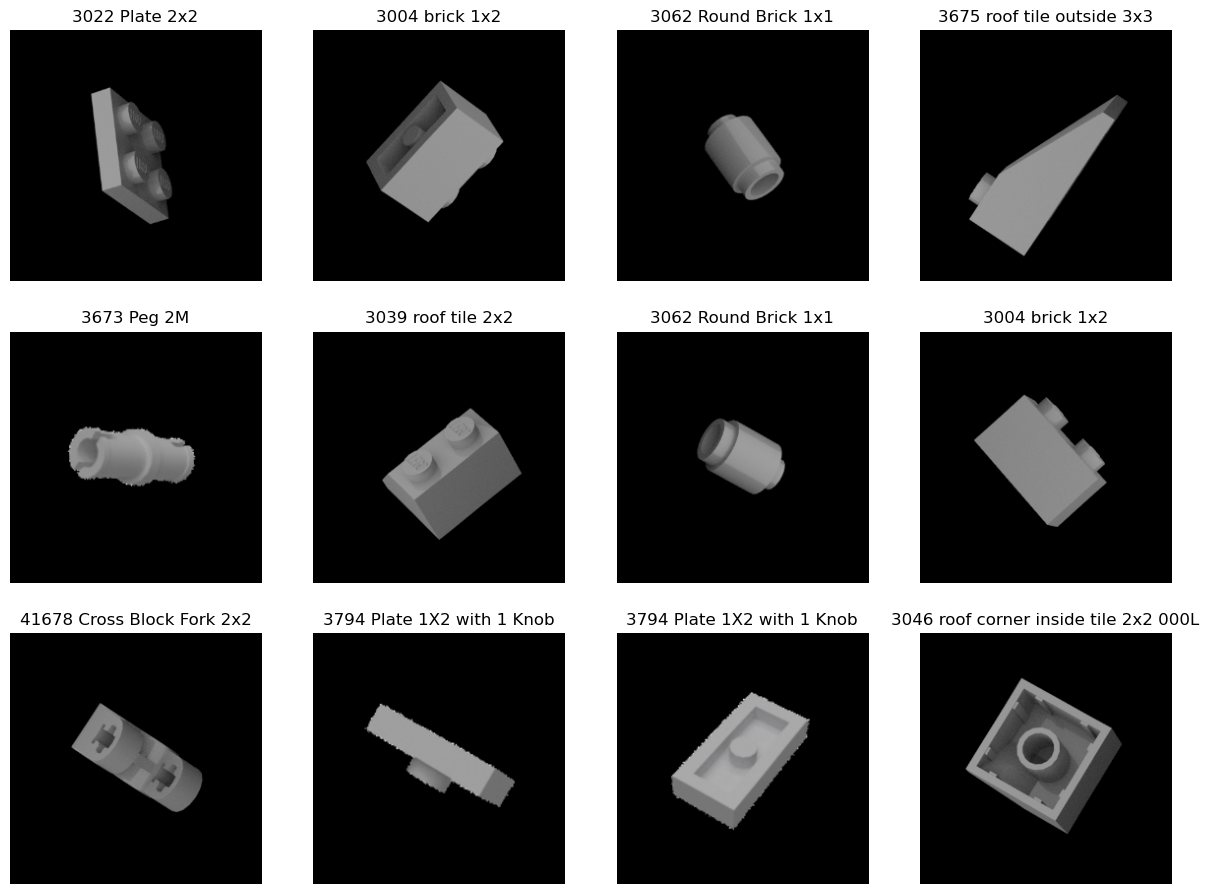

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 56

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
early_stopping = keras.callbacks.EarlyStopping(
  monitor="val_loss",
   patience=5,
   verbose=1
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[early_stopping],
    verbose=1,
    epochs=50
)

Epoch 1/50
183/183 [==============================] - 59s 315ms/step - loss: 2.7518 - accuracy: 0.3035 - val_loss: 2.1900 - val_accuracy: 0.3906
Epoch 2/50
183/183 [==============================] - 58s 315ms/step - loss: 2.0193 - accuracy: 0.4269 - val_loss: 1.8886 - val_accuracy: 0.4517
Epoch 3/50
183/183 [==============================] - 58s 317ms/step - loss: 1.8247 - accuracy: 0.4626 - val_loss: 1.7101 - val_accuracy: 0.4787
Epoch 4/50
183/183 [==============================] - 58s 317ms/step - loss: 1.7055 - accuracy: 0.4973 - val_loss: 1.6075 - val_accuracy: 0.5185
Epoch 5/50
183/183 [==============================] - 59s 321ms/step - loss: 1.6061 - accuracy: 0.5202 - val_loss: 1.5519 - val_accuracy: 0.5284
Epoch 6/50
183/183 [==============================] - 59s 323ms/step - loss: 1.5273 - accuracy: 0.5377 - val_loss: 1.4265 - val_accuracy: 0.5597
Epoch 7/50
183/183 [==============================] - 58s 319ms/step - loss: 1.4388 - accuracy: 0.5631 - val_loss: 1.3489 - val_ac

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

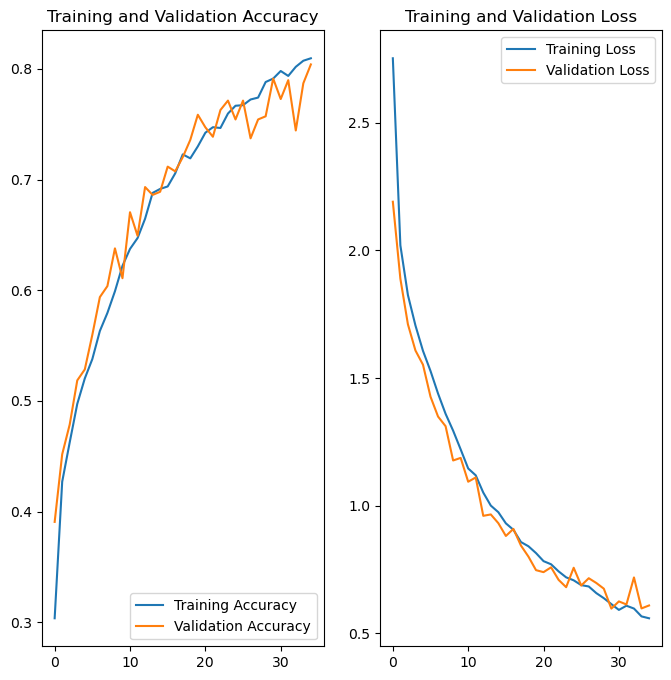

In [51]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(35), acc, label='Training Accuracy')
plt.plot(range(35), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(35), loss, label='Training Loss')
plt.plot(range(35), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
scores = model.evaluate(test_ds)

24/24 [==============================] - 3s 105ms/step - loss: 0.5780 - accuracy: 0.8060


first image to predict
actual label: 3005 brick 1x1
1/1 [==============================] - 0s 204ms/step
predicted label: 3005 brick 1x1


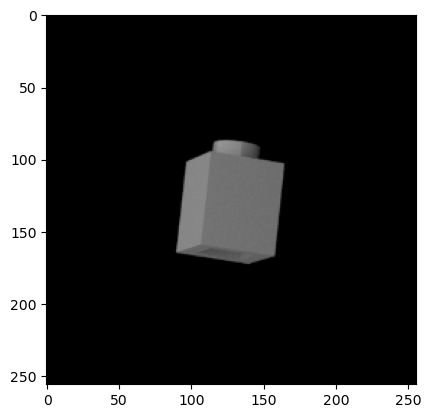

In [53]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


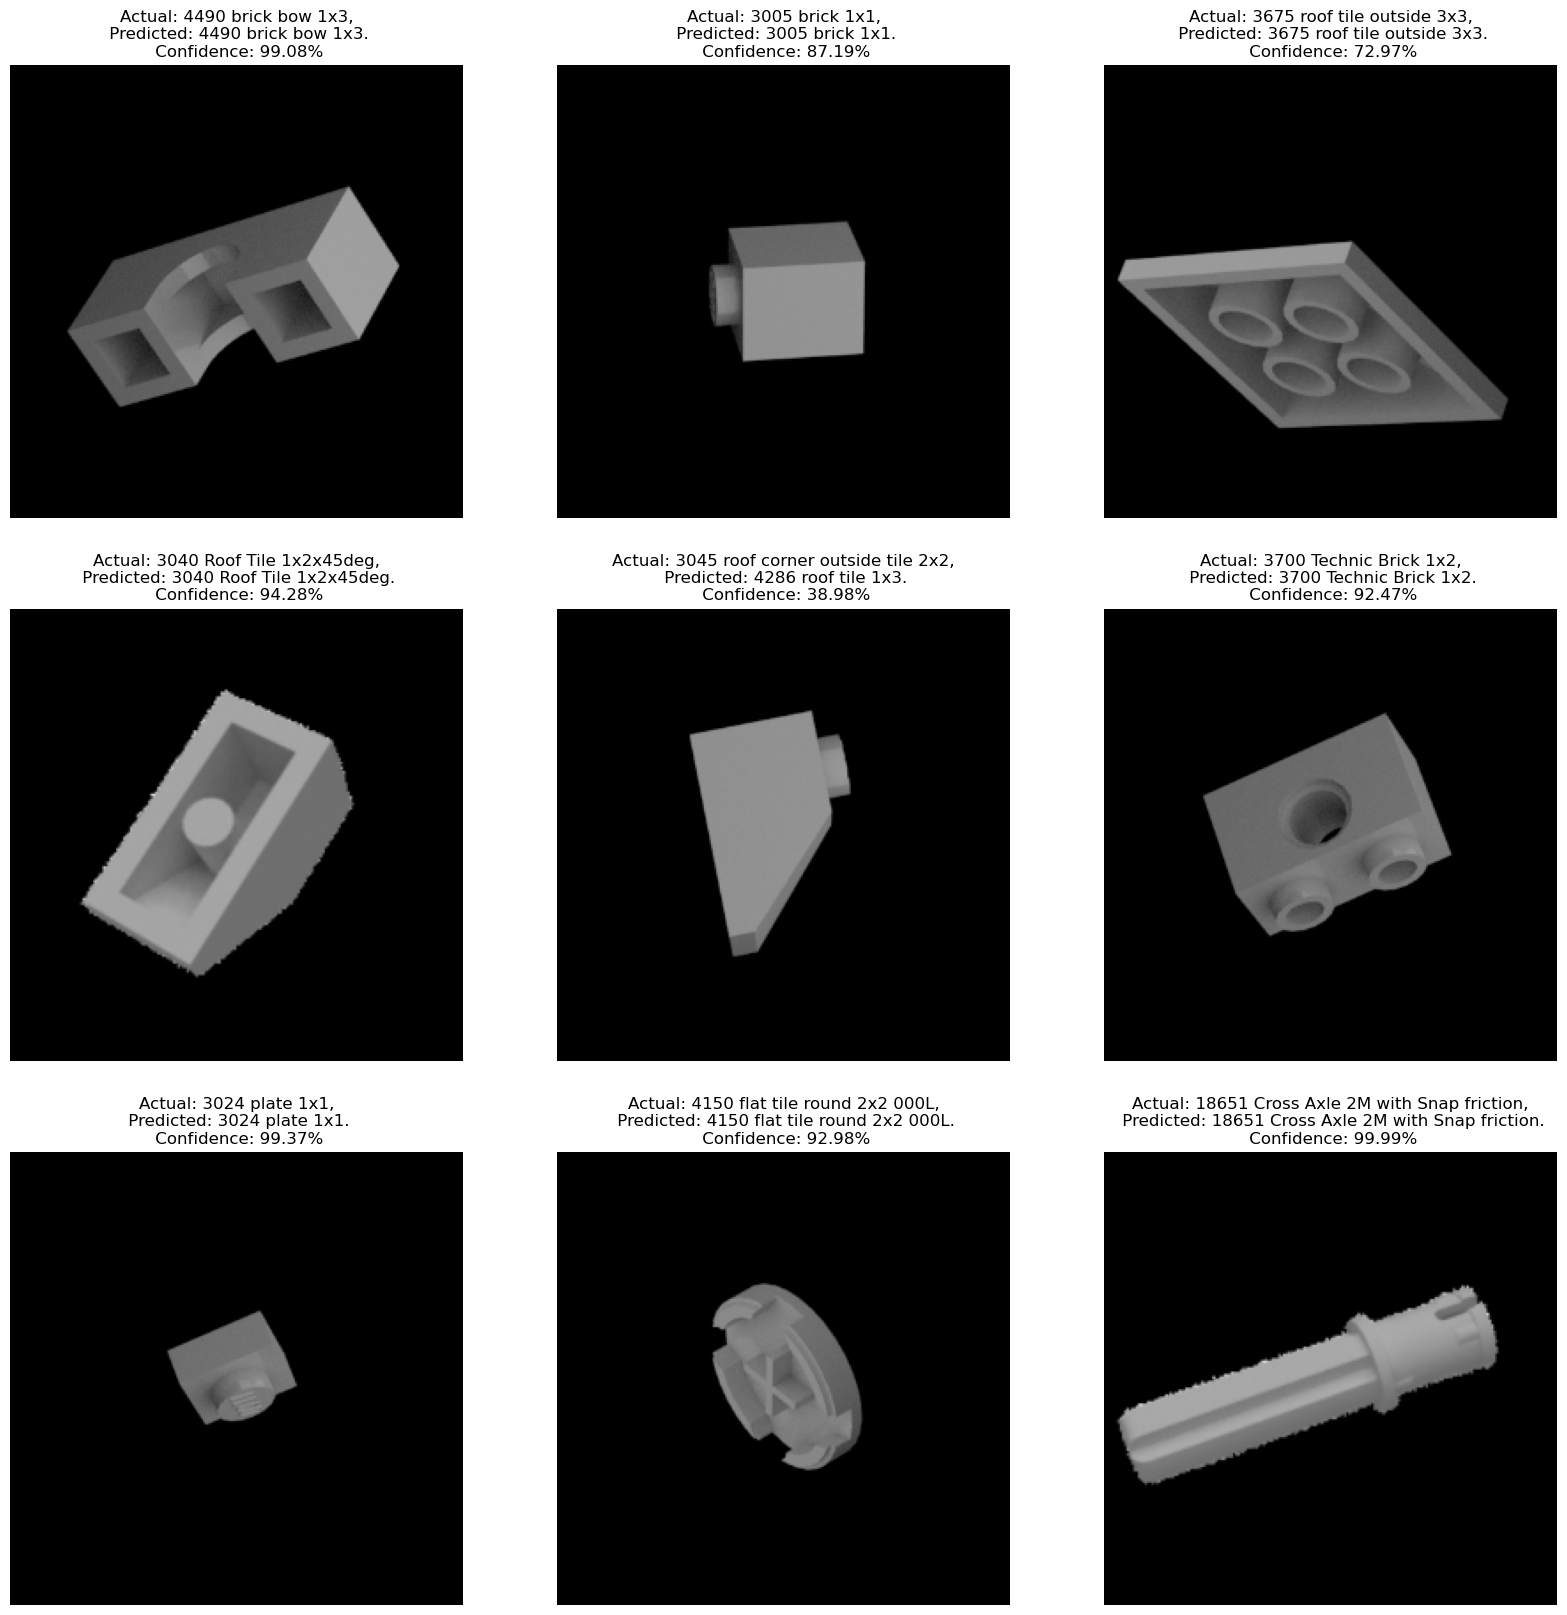

In [55]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [56]:
model_version="Lego_Bricks_50"
model.save(f"./Models/{model_version}")

INFO:tensorflow:Assets written to: ./Models/Lego_Bricks_50\assets


INFO:tensorflow:Assets written to: ./Models/Lego_Bricks_50\assets


In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score

# 获取测试集上的预测结果
predictions = model.predict(test_ds)
y_true = []
y_pred = []

# 将测试集中的真实标签和预测结果收集起来
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(model.predict(images), axis=1).numpy())

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix

1/1 [==============================] - 0s 95ms/step


array([[6, 0, 0, ..., 0, 0, 0],
       [0, 6, 0, ..., 0, 1, 0],
       [0, 0, 8, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 9, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 7]], dtype=int64)

In [59]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [60]:
# Calculate class-wise accuracy
class_accuracy = {}
for i in range(n_classes):
    true_positive = conf_matrix[i][i] if i < conf_matrix.shape[0] else 0
    total_predicted = sum(conf_matrix[i]) if i < conf_matrix.shape[0] else 0
    
    # Avoid division by zero
    if total_predicted != 0:
        class_accuracy[class_names[i]] = true_positive / total_predicted
    else:
        class_accuracy[class_names[i]] = 0  # Set accuracy to 0 for classes with no predictions

# Print class-wise accuracies
for class_name, accuracy in class_accuracy.items():
    print(f'Class: {class_name}, Accuracy: {accuracy}')

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred,pos_label='pos_label',average='weighted')
overall_recall = recall_score(y_true, y_pred,pos_label='pos_label',average='weighted')
overall_f1 = f1_score(y_true, y_pred,pos_label='pos_label',average='weighted')
print(f'Overall Accuracy: {overall_accuracy}')
print(f'Overall Precision: {overall_precision}')
print(f'Overall Recall: {overall_recall}')
print(f'Overall F1: {overall_f1}')

Class: 11214 Bush 3M friction with Cross axle, Accuracy: 1.0
Class: 14719 flat tile corner 2x2, Accuracy: 0.6
Class: 15672 roof tile 1x2, Accuracy: 1.0
Class: 18651 Cross Axle 2M with Snap friction, Accuracy: 0.8571428571428571
Class: 2357 brick corner 1x2x2, Accuracy: 0.9
Class: 2420 plate corner 2x2, Accuracy: 0.7
Class: 2780 Peg with friction, Accuracy: 0.9333333333333333
Class: 27925 flat tile round 2x2, Accuracy: 0.5454545454545454
Class: 3001 brick 2x4, Accuracy: 0.25
Class: 3002 brick 2x3, Accuracy: 1.0
Class: 3003 brick 2x2, Accuracy: 1.0
Class: 3004 brick 1x2, Accuracy: 0.8076923076923077
Class: 3005 brick 1x1, Accuracy: 0.9833333333333333
Class: 3010 brick 1x4, Accuracy: 0.5
Class: 3020 plate 2x4, Accuracy: 0.6666666666666666
Class: 3021 plate 2x3, Accuracy: 0.8
Class: 3022 Plate 2x2, Accuracy: 0.9354838709677419
Class: 3023 Plate 1x2, Accuracy: 0.8333333333333334
Class: 3024 plate 1x1, Accuracy: 0.8571428571428571
Class: 3037 roof tile 1x4, Accuracy: 0.2857142857142857
Class

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'pos_label') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'pos_label') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'pos_label') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
